<div class="report-header"><div class="aictx-logo"></div>
<span class="report-type">Technical Report</span><br />
<span class="report-author">Author: Felix Bauer</span><br />
<span class="report-date">27th June, 2018</span>
</div><h1>Multi-dimensional readout for ECG Anomaly detection</h1>

Previously our networks for ECG anomaly detection had a one-dimensional output that was trained to distinguish two classes: normal ECG and abnormal ECG, where the latter comprised a set of different anomalies. 

Alternatively, the output could consist of multiple units and each is trained to recognize one specific anomaly type. Whenever as there is a detection in any of the output units, the signal is classified as abnormal. This report compares the two approaches with respect to their detection accuracy. 

<br>
### Housekeeping and import statements

Loading BokehJS ...


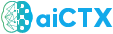

In [1]:
# - Imports

import numpy as np
from typing import Callable
from brian2 import second
from matplotlib import pyplot as plt
plt.ion()

# Local modules
import TimeSeries as ts
from ecg import signal_and_target
import network as nw
import analysis as an

from layers.feedforward.rate import PassThrough
from layers.recurrent.iaf_brian import RecIAFBrian as Rec
from layers.feedforward.exp_synapses_manual import FFExpSyn as FFsc
from layers.recurrent.weights import IAFSparseNet

# Plotting
from bokeh import plotting as bk
from bokeh.io import output_notebook
output_notebook()

# - Initialisation code to include custom report styles
from IPython.core.display import HTML
def css_styling():
    styles = open("aictx-report.css", "r").read()
    return HTML(styles)
css_styling()

## Network definition and equation

<br>
### Reservoir

We will look at a randomly connected reservoir that consists of $n_{res} = 512$ spiking LIF neurons that are recurrently connected by exponential synapses. Their state at time $t$ is described by a vector $\mathbf{V}(t)$, which can be understood as the neuron potential and evolves according to the following differential equation:

\begin{align}
\boldsymbol{\tau}_m \odot \mathbf{\dot{V}}(t) & = R_m \cdot \mathbf{I}_{total} + \mathbf{V}_{rest} - \mathbf{V}(t) \\ 
\mathbf{I}_{total} & = \mathbf{I}_{in}(t) + \mathbf{I}_{syn}(t) + \mathbf{I}_{bias} \\
\mathbf{\dot{I}}_{syn} & = W_{rec} \cdot \mathbf{S}(t) - \boldsymbol{\tau}_s^{-1} \odot \mathbf{I}_{syn}(t)
\end{align}

Here, $\odot$ describes element-wise multiplication. $\mathbf{S}(t)$, $\boldsymbol{\tau}_s^{-1}$, $\mathbf{V}_{rest}$ and $\mathbf{I}_{bias}$ are vectors containing the spike trains of the neurons in the same reservoir, the synaptic time constants, the neurons' resting potentials and bias currents, respectively. $W_{rec}$ is the $n_{res} \times n_{res}$ recurrent weight matrix.

The input current is given as 
$$\mathbf{I}_{in}(t) = W_{in} \cdot f_{in}(t),$$
where $W_{in}$ is the $n_{res} \times 1$ input weight matrix and $f_{in}(t)$ the one-dimensional ECG input signal.

The membrance resistance $R_m$ is assumed to be constant over time. Its value can be implicity incorporated by scaling $W_{in}$, $W_{res}$ and $\mathbf{I}_{bias}$ and will therefore be set to $1 \Omega$.

A neuron spikes whenever its membrane potential crosses a threshold and is then reset to a reset potential. It will be refractory for a time ${\tau_r}$. Threshold and reset potentials are defined in the vectors $\mathbf{V}_{thr}$ and $\mathbf{V}_{reset}$, respectively.

For the simulations in this report, each input weight is drawn uniformly between -1 and 1. Recurrent weights are non-zero with a probability $p_{connect} \equiv 0.4$, in which case they are drawn from a Gaussian distribution with mean $\mu \equiv \frac{-0.045}{p_{connect} \cdot n_{res}}$ and standard deviation $\sigma \equiv \frac{0.0055}{\sqrt{p_{connect}}}$.

Constant parameters are the same for all neurons or synapses and given as
\begin{align}
\tau_s & \equiv 1750 \ \text{ms}, \\
\tau_m & \equiv 175 \ \text{ms}, \\
\tau_r & \equiv 0 \ \text{ms}, \\
V_{rest} & \equiv -65 \ \text{mV}, \\
V_{reset} & \equiv -65 \ \text{mV}, \\
I_{bias} & \equiv 10.5 \ \text{mA}.
\end{align}

### Readout

The continuous readout signal is obtained by a convolution and weighted sum of the reservoir spike trains, with an exponential kernel $\kappa$:
\begin{align}
\mathbf{f}_{out}(t) & = (\kappa * W_{out} \cdot \mathbf{S})(t) \\
\kappa(t) & = exp(-\frac{t}{\tau_o})
\end{align}

The readout time constant $\tau_o$ is set to 175 ms, here. $W_{out}$ is a $n_{out} \times n_{res}$ matrix of readout weights, with $n_{out}$ the number of output dimensions. 

Weights are trained by ridge regression, with a regularization constant of 0.001.

<br>
## Simulation

We will first create a network for training the one-dimensional readout. After training, a new input will be used to determine a threshold that results in the lowest number of errors. An error is either a missed anomaly or if the network falsely indicates that the signal is abnormal. If between two anomalies multiple such false detections happen, they are only counted as one. Then the 1D output is tested with a third input signal.

For training the multi-dimensional readout and determining the thresholds, we use the same reservoir and procedure. Thresholds are determined independently for each output dimension.

For both types of readout the thresholds that are found for different inputs tend to have a strong variance. Therefore the threshold finding process is repeated several times with different inputs. The final thresholds are then determined by taking the mean over those from each repetition.

<br>
### Set network and simulation parameters

Because training and finding the thresholds takes a lot of computation time, weights and thresholds have been pre-trained offline and only need to be loaded into the simulation. For running training and finding thresholds anew, the `bPreloadWeightsAndThresholds` parameter can be set to `False`.

In [2]:
### --- Setup

# - Preload weights and thresholds to save computation time
bPreloadWeightsAndThresholds = True

# - Simulation parameters
tDt = 0.005  # Length of time step in seconds

nTrialsTr = 3000  # Number ECG rhythms for training
nTrialsTe = 2000  # Number ECG rhythms for testing
nTrialsVa = 1000  # Number ECG rhythms for validation
nRepsVa = 10 # Number repetitions of validation runs    

tDurBatch  = 250 # Training batch duration
fRegularize = 0.001  # Regularization parameter for training with ridge regression

# - Network parameters

nDimIn = 1  # Input dimensions
nDimOut = 9  # Output dimensions for multi-dimensional output

nResSize = 512  # Reservoir size
fDensity = 0.4  # Recurrent connection density
tTauN = 35 * tDt  # Reservoir neuron time constant
tTauS = 350 * tDt # Reservoir synapse time constant
tTauO = 35 * tDt  # Readout time constant

# - Input signal parameters

fHeartRate = 1  # Heart rate in rhythms per second

# Probabilities for anomalies in ECG rhythms
pNormal = 0.8  # Probability of normal input rhythm
pAnomal = (1. - pNormal) / 6.  # Probability of abnormal input rhythm
dProbs = {
    "complete_normal": pNormal,     # Normal ECG
    "complete_noP": pAnomal,      # Missing P-wave
    "complete_Pinv": pAnomal,     # Inverted P-wave
    "complete_noQRS": pAnomal,    # Missing QRS complex
    "complete_Tinv": pAnomal,     # Inverted T-wave
    "complete_STelev": pAnomal,   # Elevated ST-segment
    "complete_STdepr": pAnomal,   # Depressed ST-segment
    # "complete_tach": pAnomal,     # Tachycardia
    # "complete_brad": pAnomal,     # Bradycardia
} 

kwSignal = {
    "strTargetMethod": "segment-extd",  # Method for labelling targets
    "dProbs": dProbs,
    "fHeartRate": fHeartRate,
    "tDt": tDt,
    "bVerbose": True,
    "nMinWidth": int(0.5*fHeartRate / tDt),
    "bVerbose" : False,
}

### Functions for signal generation and training

In [3]:
### --- funciton definitions
  
def cTrain(net: nw.Network, dtsSignal: dict, bFirst: bool, bFinal: bool):
    """
    cTrain - Train layer flOut with input from dtsSignal and tsTgtTr as
             target. Use fRegularize as parameter for ridge regression.
             Training may span several batches. This funciton is to be
             passed on to net and will be called after each batch.
    :param net:     Network containing the layer
    :param dtsSignal: dict with TimeSeries from network evolutions
    :param bFirst:    bool True if this is the first batch of a training
    :param bLast:    bool True if this is the final batch of a training
    """
    # - Input to flOut
    tsInput = dtsSignal['reservoir']
    # - Infer time range of current batch
    tStart = dtsSignal['external'].tStart
    tStop = dtsSignal['external'].tStop
    # - Sample target within time range of current batch
    tsTarget1D = tsTgtTr1D.resample_within(tStart, tStop)
    tsTargetMulti = tsTgtTrMulti.resample_within(tStart, tStop)
    # - Train the layers
    flOut1D.train_rr(tsTarget1D, tsInput, fRegularize, bFirst, bFinal)
    flOutMulti.train_rr(tsTargetMulti, tsInput, fRegularize, bFirst, bFinal)

def ts_ecg_target(nRhythms: int, **kwargs) -> (ts.TimeSeries, ts.TimeSeries):
    """
    ts_ecg_target - Generate two time series, one containing an ECG signal
                   and the other the corresponding target.
    :param nRhythms:    int Number of ECG rhythms in the input
    :tDt:               float Size of a single time step
    :kwargs:            dict Kwargs that are passed on to signal_and_target
    """

    # - Input signal and target
    vfInput, mfTargetMulti = signal_and_target(nTrials=nRhythms, **kwargs)
    vfTarget1D = mfTargetMulti.any(axis=1)
    
    # - Time base
    tDt = kwargs['tDt']
    vtTime = np.arange(0, vfInput.size * tDt, tDt)[: vfInput.size]
    
    # - Genrate time series
    tsInput = ts.TimeSeries(vtTime, vfInput)
    tsTargetMulti = ts.TimeSeries(vtTime, mfTargetMulti)
    tsTarget1D = ts.TimeSeries(vtTime, vfTarget1D)

    return tsInput, tsTargetMulti, tsTarget1D

### Network generation

For the multi-dimensional readout we will not create an actual network. Instead we pass the reservoir outputs of the simulations with the 1D readout to the multi-dimensional readout layer. This way we save computation time and ensure that both output layers are trained and tested under the same conditions. 

In [4]:
### --- Network generation

# - Input and recurrent weight matrices
if bPreloadWeightsAndThresholds:
    dPreloaded = np.load('multi-dim.npz')
    mfW_in = dPreloaded['mfW_in']
    mfW_res = dPreloaded['mfW_res']
else:    
    mfW_in = 2 * (np.random.rand(nDimIn, nResSize) - 0.5)
    mfW_res = IAFSparseNet(nResSize=nResSize, fDensity=fDensity)

# - Layers
flIn = PassThrough(mfW=mfW_in, tDt=tDt, tDelay=0, strName='input')
rlRes = Rec(mfW=mfW_res, vtTauN=tTauN, vtTauSynR=tTauS, tDt=tDt * second, strName="reservoir")
flOut1D = FFsc(mfW=np.zeros((nResSize, 1)), tTauSyn=tTauO, tDt=tDt, strName="output")
flOutMulti = FFsc(mfW=np.zeros((nResSize, nDimOut)), tTauSyn=tTauO, tDt=tDt, strName="output")

# - Network
net1D = nw.Network(flIn, rlRes, flOut1D)

### Run simulation
In the following the readtouts will be trained and tested. This might take a while.

<br>
#### Training and thresholds  

In [5]:
if not bPreloadWeightsAndThresholds:
    ### --- Training
    
    # - Signal generation
    tsInTr, tsTgtTrMulti, tsTgtTr1D = ts_ecg_target(nTrialsTr, **kwSignal)
    
    # - Function cTrain calls training routines for both readouts
    net1D.train(cTrain, tsInTr, tDurBatch=tDurBatch)
    net1D.reset_all()

    
    ### --- Find Thresholds
    
    # - Lists for storing thresholds
    lfThr1D = []
    lvfThrM = []

    # - Validation runs
    for i in range(nRepsVa):

        print('\tRun {} of {}'.format(i+1, nRepsVa), end='\r')

        # Signal generation
        tsInVa, tsTgtVa, tsTgtVa1D = ts_ecg_target(nTrialsVa, **kwSignal)

        # Simulation
        dVa1D = net1D.evolve(tsInVa, bVerbose=False)
        net1D.reset_all()
        tsOutVa = flOut.evolve(dVa1D['reservoir'], tDuration=tsInVa.tDuration)
        flOut.reset_all()

        # Threshold for 1D
        lfThr1D.append(an.find_threshold(
            vOutput=dVa1D['output'].mfSamples,
            vTarget=tsTgtVa1D.mfSamples.flatten(),
            nWindow=int(fHeartRate / tDt),
            nClose=int(fHeartRate / tDt),
            nAttempts=16,
            nRecursions=4,
        ))

        # Threshold for multi
        lvfThrM.append(an.find_all_thresholds_multi(
            mOutput=tsOutVa.mfSamples,
            mTarget=tsTgtVa.mfSamples,
            nWindow=int(fHeartRate / tDt),
            nClose=int(fHeartRate / tDt),
            nAttempts=16,
            nRecursions=4,
            bStrict=False,
        )[:,0])

        del dVa1D, tsOutVa

    # - Average over stored thresholds
    vfThr = np.mean(lvfThrM, axis=0)
    fThr1D = np.mean(lfThr1D)

else:
    # - Preload weights
    flOut1D.mfW = dPreloaded['mfW_out_1D']
    flOutMulti.mfW = dPreloaded['mfW_out_multi']
    
    # - Preload thresholds
    fThr1D = np.asscalar(dPreloaded['fThr1D'])
    vfThrMulti = dPreloaded['vfThrMulti']
    
print('Using {:.4f} as threshold for 1D output'.format(fThr1D))
print("Using following thresholds for multi-d. output:")
print(vfThrMulti[:6])

Using 0.8169 as threshold for 1D output
Using following thresholds for multi-d. output:
[ 0.396608    0.39255467  0.343104    0.39037867  0.76189867  0.318976  ]


#### Testing

In [6]:
# - Signal generation
tsInTe, tsTgtTeMulti, tsTgtTe1D = ts_ecg_target(nTrialsTe, **kwSignal)

# - Testing
print('Evolving reservoir and 1D readout', end='\r')
dTe = net1D.evolve(tsInTe, bVerbose=False)
vfOutTe1D = dTe['output'].mfSamples
net1D.reset_all()
print('Evolving multi-dim. readout       ', end='\r')
mfOutTeMulti = flOutMulti.evolve(dTe['reservoir'],
                                 tDuration=tsTgtTeMulti.tDuration).mfSamples
flOutMulti.reset_all()

# - Analysis
print('Analysis 1D:                 ')
dAnalysis1D = an.analyze(
    vfOutTe1D,
    tsTgtTe1D.mfSamples.flatten(),
    tsInTe.mfSamples,
    fThr1D,
    nWindow=int(fHeartRate / tDt),
    nClose=int(fHeartRate / tDt),
    bPlot=False,
    mfTarget=tsTgtTeMulti.mfSamples,
)
print('\nAnalysis multi-d.:')
dAnalysisMulti = an.analyze_multi(
    mfOutTeMulti,
    tsTgtTeMulti.mfSamples,
    tsInTe.mfSamples,
    vfThrMulti,
    nWindow=int(fHeartRate / tDt),
    nClose=int(fHeartRate / tDt),
    bPlot=False,
)

Analysis 1D:                      
Sensitivity : 77.9% (300 of 385 anomalies detected)
Specificity : 99.3% (265 of 267 normal intervals correct)
87 Errors: 
 85 of 385 anomalies missed, 2 false detections (in 2 intervals)

Analysis multi-d.:
Sensitivity : 87.8% (338 of 385 anomalies detected)
Specificity : 94.8% (253 of 267 normal intervals correct)
61 Errors: 
 47 of 385 anomalies missed, 15 false detections (in 14 intervals)


### Results

The output above compares the sensitivity, specificity, number of missed anomalies, number of false detections for the two readouts. For the specificity the number of anomaly-free intervals with one or more detections is counted, not the number of detections itself.

The number of missed anomalies should be slightly higher with the one-dimensional readout, while the number of false detections tends to be a bit higher with the multi-dimensional readout. All in all, results normally do not vary strongly.

<br>
#### Individual anomaly types

Nevertheless, there is a difference if we look at how the readouts compare for individual anomaly types.

In [7]:
# - Show statistics for individual symptom types

lstrSymptomFullNames = ['Inverted P-wave', 'Missing P-wave', 'Missing QRS-complex', 'Inverted T-wave', 'Elevated ST-segment', 'Depressed ST-segment']

for iSymptom in dAnalysis1D['dSymptoms'].keys():
    if iSymptom < len(lstrSymptomFullNames):
        print(lstrSymptomFullNames[iSymptom] + ':')
        print( '1D: {:.1%}'.format(dAnalysis1D['dSymptoms'][iSymptom]['fSensitivity'])
              +'\tMulti: {:.1%}\n'.format(dAnalysisMulti['dSymptoms'][iSymptom]['fSensitivity']) 
             )

Inverted P-wave:
1D: 90.9%	Multi: 95.5%

Missing P-wave:
1D: 57.4%	Multi: 55.7%

Missing QRS-complex:
1D: 13.6%	Multi: 53.0%

Inverted T-wave:
1D: 98.4%	Multi: 87.5%

Elevated ST-segment:
1D: 93.8%	Multi: 98.5%

Depressed ST-segment:
1D: 92.1%	Multi: 87.3%



Most types of anomalies are equally well detected by both outputs. However, for the missing QRS-complex detection is signifiacantly more reliable with the multi-dimensional readout. 

<br>
## Conclusion

The one-dimensional readout shows strong deficits for one anomaly type, the QRS-complex. The reason might be that the single output neuron only can draw a hyperplane in reservoir state space to separate states that correspond to anomalies and states corresponding to normal inputs. With the current reservoir it seems not possible to do this in a way that all anomaly types (mostly) lie on the correct side of the plane.

On the other hand, the multidimensional readout implicitly introduces an additional final layer. Each dimension of the readout is compared to an individual threshold and whenever any of the thresholds is crossed, the final one-dimensional output indicates an anomaly. This is analogous to an output unit that receives inputs from the readout neurons and weights them according to the inverse of the corresponding thresholds. It then takes the maximum value of these weighted inputs and indicates an anomaly when this value is above 1. Apparently this layer helps in distinguishing the anomalies correctly.

The drawback of this approach is the increased computation time that comes from finding suitable thresholds, or in other words from training the implicit additional layer.

There are several options for potentially improving this process. On the one hand there might be a more efficient way of determining the thresholds. This is currently done by a grid search which tries different thresholds and chooses the one that results in the lowest number of errors.

Besides, since mainly the detection of missing-QRS anomalies is affected, it might be sufficient to have a dedicated readout unit only for this type of anomaly and use a common readout for all the others. This way the number of readouts and with it the number of thresholds that need to be found is reduced to two.

Apart from that, reservoir activites should be examined more closely in order to find out what makes it so hard to detect this specific anomaly. Possibly by adapting the reservoir, detection can be improved further.

<hr />
#### Colophon
Live notebook requires a Jupyter Notebook server.

GitLab repository location: https://gitlab.com/ai-ctx/network-architectures/blob/c752d67f032761a06030cfa530042a2b3f409055/NetworksPython/Multi-dimensional%20readout%20for%20ECG%20Anomaly%20detection.ipynb